In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge
from best_subset import *
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

Sklearn's version: 1.2.2


#### Load data and add noise

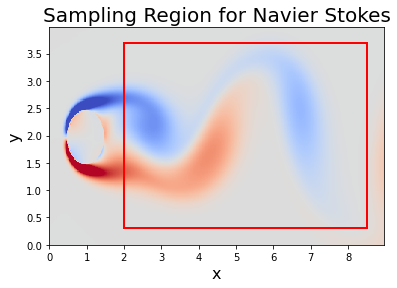

In [2]:
# Load data
steps = 151
n = 449
m = 199
# U = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_U.npy')
# V = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_V.npy')
# W = np.load('../../PDE-FIND/Datasets/course_timestep_cylinder/Cylinder_W.npy')
U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

dt = 0.2
dx = 0.02
dy = 0.02

x = np.arange(n)*dx
y = np.arange(m)*dy
t = np.arange(steps)*dt

# plot the data
xx, yy = np.meshgrid(x, y)
plt.pcolor(xx,yy,W[:,:,75].T,cmap='coolwarm', vmin=-4, vmax=4, shading='auto')

# Cut out the portion of the data before the cylinder
xmin = 100*dx
xmax = 425*dx
ymin = 15*dy
ymax = 185*dy
plt.plot([xmin,xmin],[ymin,ymax],'r',linewidth = 2)
plt.plot([xmax,xmax],[ymin,ymax],'r',linewidth = 2)
plt.plot([xmin,xmax],[ymin,ymin],'r',linewidth = 2)
plt.plot([xmin,xmax],[ymax,ymax],'r',linewidth = 2)
plt.xlim([0,n*dx-dx])
plt.ylim([0,m*dy])
plt.title('Sampling Region for Navier Stokes', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)

xmin = 100
xmax = 425
ymin = 15
ymax = 185
x = x[xmin:xmax]
y = y[ymin:ymax]
W = W[xmin:xmax,ymin:ymax,:]
U = U[xmin:xmax,ymin:ymax,:]
V = V[xmin:xmax,ymin:ymax,:]
n,m,steps = W.shape

# Add in noise with magnitude equal to 1% of std dev of data
noise_lv = 1
np.random.seed(0)
W = W + noise_lv*0.01*np.std(W)*np.random.randn(n,m,steps)
U = U + noise_lv*0.01*np.std(U)*np.random.randn(n,m,steps)
V = V + noise_lv*0.01*np.std(V)*np.random.randn(n,m,steps)

#### Denoise

In [3]:
wn = W.T
un = U.T
vn = V.T

div = 30
ws = max(un[0].shape)//div; po = 2
if ws%2 == 0: ws -=1
    
wnd = []
for i in trange(wn.shape[0]):
    wnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(wn[i]))
W = np.stack(wnd, axis=0).T
    
und = []
for i in trange(un.shape[0]):
    und.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[i]))
U = np.stack(und, axis=0).T

vnd = []
for i in trange(vn.shape[0]):
    vnd.append(sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[i]))
V = np.stack(vnd, axis=0).T

del und, vnd, un, vn

100%|████████████████████████████████████████████████████████████████████████████████████████| 151/151 [00:01<00:00, 138.54it/s]


In [4]:
Wn = W.reshape(n*m,steps)
Un = U.reshape(n*m,steps)
Vn = V.reshape(n*m,steps)
uwn,sigmawn,vwn = np.linalg.svd(Wn, full_matrices=False); vwn = vwn.T
uun,sigmaun,vun = np.linalg.svd(Un, full_matrices=False); vun = vun.T
uvn,sigmavn,vvn = np.linalg.svd(Vn, full_matrices=False); vvn = vvn.T
dim_w = 26
dim_u = 20
dim_v = 20
W = uwn[:,0:dim_w].dot(np.diag(sigmawn[0:dim_w]).dot(vwn[:,0:dim_w].T)).reshape(n,m,steps)
U = uun[:,0:dim_u].dot(np.diag(sigmaun[0:dim_u]).dot(vun[:,0:dim_u].T)).reshape(n,m,steps)
V = uvn[:,0:dim_v].dot(np.diag(sigmavn[0:dim_v]).dot(vvn[:,0:dim_v].T)).reshape(n,m,steps)
del Wn, Un, Vn

#### Applying best-subset regression on the candidate library

In [5]:
def build(*args): return np.stack([a.ravel() for a in args], axis=-1)

acc=4
d_dx = FinDiff(0, dx, 1, acc=acc)
d_dxx = FinDiff(0, dx, 2, acc=acc)
d_dy = FinDiff(1, dy, 1, acc=acc)
d_dyy = FinDiff(1, dy, 2, acc=acc)
d_dt = FinDiff(2, dt, 1, acc=acc)

W_x, W_y, W_xx, W_yy = d_dx(W), d_dy(W), d_dxx(W), d_dyy(W)

In [6]:
data_names = ['w', 'u', 'v']
diff_names = ['w_{x}', 'w_{y}', 'w_{xx}', 'w_{yy}']
inter_names = data_names + diff_names
inter = []
for i, data in enumerate([W, U, V]):
    for j, diff in enumerate([W_x, W_y, W_xx, W_yy]):
        inter.append(data*diff)
        inter_names.append(data_names[i]+diff_names[j])
inter_names

['w',
 'u',
 'v',
 'w_{x}',
 'w_{y}',
 'w_{xx}',
 'w_{yy}',
 'ww_{x}',
 'ww_{y}',
 'ww_{xx}',
 'ww_{yy}',
 'uw_{x}',
 'uw_{y}',
 'uw_{xx}',
 'uw_{yy}',
 'vw_{x}',
 'vw_{y}',
 'vw_{xx}',
 'vw_{yy}']

In [7]:
X_pre = build(W, U, V, d_dx(W), d_dy(W), d_dxx(W), d_dyy(W), *inter)
y_pre = d_dt(W).ravel().reshape(-1, 1)

In [8]:
best_subsets = solvel0(X_pre, y_pre, is_normal=False, max_complexity=1+X_pre.shape[-1]//2)
best_subsets

  0%|                                                                                                    | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/it]


[(3,),
 (11, 16),
 (6, 11, 16),
 (5, 6, 11, 16),
 (0, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 16),
 (0, 2, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 14, 16),
 (0, 2, 3, 5, 6, 11, 13, 14, 16),
 (0, 2, 3, 5, 6, 8, 11, 13, 14, 16)]

#### Model selection by the UBIC (Algorithm 1)

In [9]:
tau = 3
# scale = 1
scale = np.log(len(y_pre))
per = 75

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre, y_pre), u_type='cv1', take_sqrt=True)
print(min(b_bics)-max(b_bics))

b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

predictions = X_pre@post_means
lower_bounds = []
for k, efi in enumerate(best_subsets):
    assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*len(efi)
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    # better use imp = abs(diff_bic/(b_bics[min(last_bc, now_bc)]*diff_com))
    # if generally now_bc < last_bc
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), imp)
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc

best_bc = last_bc
    
last_lam, last_ubic, last_bc, best_bc

-28710947.291150443
0.12455816870398502
max_lam: 6.106720590157476
3 <---> 4 0.01876412753633026


(6.106720590157476,
 array([ 8.17102043e+07,  2.94538598e+07,  3.95072384e+06, -7.45058060e-09,
         8.77757288e+06,  4.00293064e+07,  4.17739657e+07,  7.15831933e+07,
         7.52686280e+07,  7.84919257e+07]),
 3,
 3)

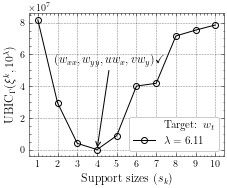

In [10]:
complexities = [len(efi) for efi in best_subsets]
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot([], [], linestyle='', marker='', label='Target: $w_t$')
    ax.plot(complexities, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(round(last_lam, 2))}$")
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)
    plt.annotate('$(w_{xx}, w_{yy}, uw_{x}, vw_{y})\checkmark$', fontsize=12, 
                 xy=(complexities[best_bc], last_ubic[best_bc]), 
                 xytext=(complexities[best_bc]-2.125, last_ubic[1]+2.5e7), 
                 arrowprops={'arrowstyle': '->'})
    ax.legend(fontsize=11)
    plt.show()

#### Percent coefficient error

In [11]:
ground_coeffs = np.array([0.01, 0.01, -1, -1])
est_coeffs = np.linalg.lstsq(X_pre[:, best_subsets[best_bc]], y_pre, rcond=None)[0].flatten()
errs = 100*np.abs(est_coeffs-ground_coeffs)/np.abs(ground_coeffs)
# (11.428620521868037, 13.445956875676883)
errs.mean(), errs.std()

(11.428620521868037, 13.445956875676883)